# Visualization of hidden layers

In this example I show how to visualize the features learnt in each main layer.

### Load the basics

In [1]:
%matplotlib inline
import context
from mlnowcasting.models.losses.example_loss import get_loss_fx
from mlnowcasting.models.params.example_params import params

from mlnowcasting.utils.torch_trainer import Torch_Trainer

dataset = '../data/datasets/example_dataset.npy'
val_dataset = '../data/datasets/example_dataset.npy'

/s/chopin/a/grad/jcuomo/699/repository


### Get the architecture
We need to modify as little bit the code, so instead of loading the architecture from a file we copy it to here.

Go to the forward() function to see the modifications

In [2]:
import torch.nn as nn
import torch

def downsampling(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels,  out_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.BatchNorm3d(out_channels, affine=True),
        nn.Dropout(0.2)
    ) 
def upsampling(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels,  out_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.BatchNorm3d(out_channels, affine=True),
        nn.Dropout(0.2)
    ) 
def upsamplingLast(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels,  out_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    ) 

class Nowcasting(nn.Module):
    def __init__(self, n_filter, dropout):
        
        super(Nowcasting, self).__init__()
        dtype = torch.cuda.FloatTensor
        
        self.e_conv00 = nn.Conv3d(in_channels=1,  out_channels=1, kernel_size=(1,3,3), stride=1, padding=(0,1,1))
        self.e_conv0 = downsampling(in_channels=1,          out_channels=n_filter)
        self.e_conv1 = downsampling(in_channels=n_filter,   out_channels=n_filter*2)
        self.e_conv2 = downsampling(in_channels=n_filter*2, out_channels=n_filter*3)
        self.e_conv3 = downsampling(in_channels=n_filter*3, out_channels=n_filter*4)
        
        self.d_conv3 = upsampling(in_channels=n_filter*4, out_channels=n_filter*3)
        self.d_conv2 = upsampling(in_channels=n_filter*3, out_channels=n_filter*2)
        self.d_conv1 = upsampling(in_channels=n_filter*2, out_channels=n_filter)
        self.d_conv0 = upsamplingLast(in_channels=n_filter,   out_channels=1)
    
    # here I changed each output to be a class variable, 
    # so the "self." is what needs to be modified if you copy a new architecture
    def forward(self, x):
        self.e0 = self.e_conv00(x)
        self.e1 = self.e_conv0(self.e0)
        self.e2 = self.e_conv1(self.e1)
        self.e3 = self.e_conv2(self.e2)
        self.e4 = self.e_conv3(self.e3)
        
        self.d3 = self.d_conv3(self.e4)
        self.d2 = self.d_conv2(self.d3+self.e3)
        self.d1 = self.d_conv1(self.d2+self.e2)
        y = self.d_conv0(self.d1+self.e1)

        return y

def get_model(n_filters, dropout):
     return Nowcasting(n_filters, dropout)

### Train the model

Train Epoch: 290 Loss: 0.008985 Val_Loss: 0.010980


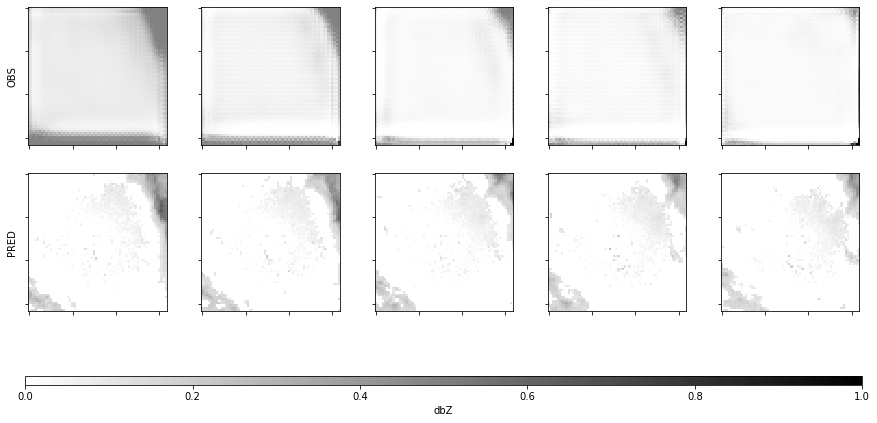

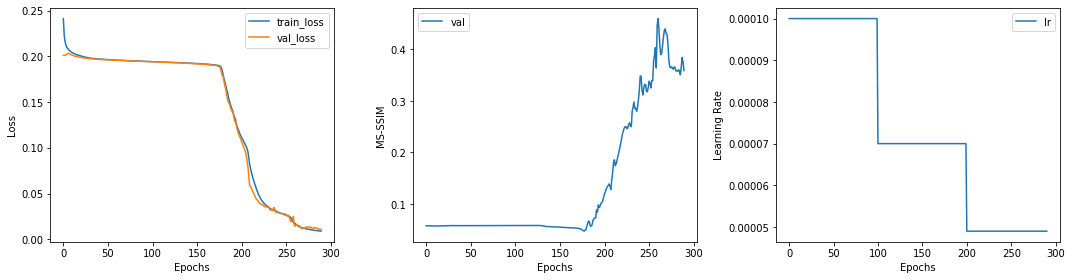

0.009969784645363688

In [3]:
T=Torch_Trainer(dataset, val_dataset, get_model, get_loss_fx)
T.train(params)

### Plot each layer output

Now I can get each layer like this:

In [11]:
T.model.e1.shape

torch.Size([1, 512, 1, 4, 4])

Notice, that the layers within sequential functions are not available. You can always expand the architecture and don't use any sequential.

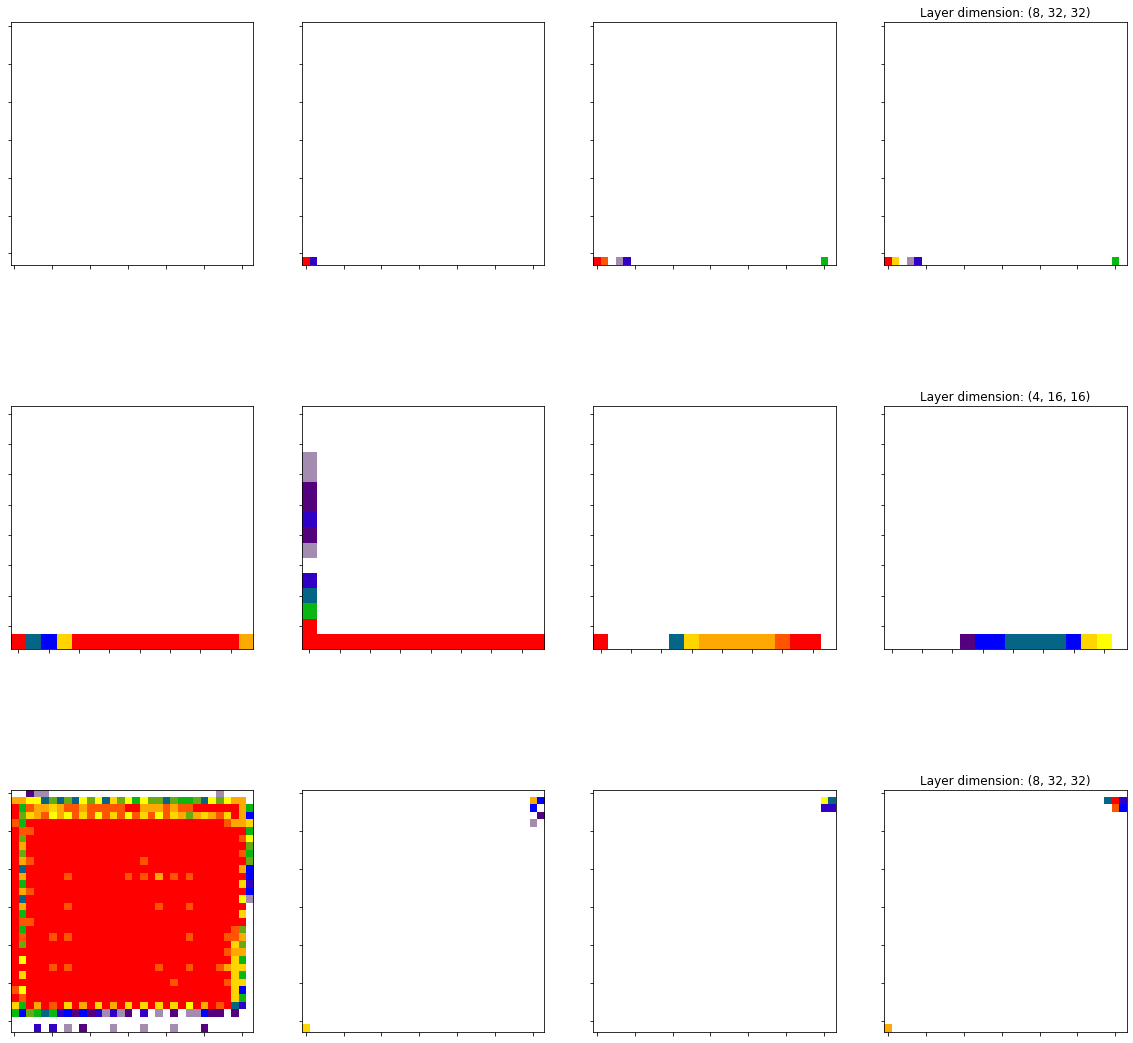

In [12]:
from mlnowcasting.utils.plot_utils import get_cmap
import matplotlib.pyplot as plt

# You can play whith whatever you need to visualize 
# here I'm taking only 1 filter
e1 = T.model.e1[0,0].detach().cpu().numpy()
e2 = T.model.e2[0,0].detach().cpu().numpy()
d1 = T.model.d1[0,0].detach().cpu().numpy()
# you can add as many layers as you want to this list
layers = [e1, e2, d1]
# and plot it
cm = get_cmap()
plt.figure(figsize=(20,20))
R = len(layers) # number of layers inspected
C = 4 # number of frames
for r in range(R):
    for c in range(C):
        plt.subplot(R,C,c+1+C*r)
        plt.imshow(layers[r][c]*70, vmin=0, vmax=70, cmap=cm)
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
    plt.title("Layer dimension: {}".format(layers[r].shape))

### Plot convolution's filter

To be able to have the convolutions' filters, you would have to expand the architecture by not using any Sequential().

In [6]:
conv_filter = T.model.e_conv00.weight.data.cpu().detach().numpy()
conv_filter.shape

(1, 1, 1, 3, 3)

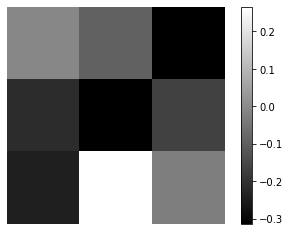

In [7]:
plt.imshow(conv_filter[0,0,0], cmap='gray')
plt.axis('off')
plt.colorbar()